## 10.3 Estimator介绍
除了第三方提供的TensorFlow高层封装API，TensorFlow从1.3版本推出Datasets同时也推出了官方支持的高层封装——tf.estimator（为了引用方便，本书将tf.estimator简称为Estimator）。因为Estimator是TensorFlow官方提供的高层API，所以它更好地整合了原生态TensorFlow提供的功能。

### 10.3.1 Estimator基本用法
类似其他的高层封装，先给出在MNIST数据集上，通过Estimator实现全连接神经网络的代码：

### 1. 模型定义。

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 1. 模型定义
# 将TensorFlow日志信息输出到屏幕
tf.logging.set_verbosity(tf.logging.INFO)

mnist = input_data.read_data_sets("../../datasets/MNIST_data", one_hot=False)

# 指定神经网络的输入层。这里所有指定的输入层都会拼接在一起作为整个神经网络的输入
feature_columns = [tf.feature_column.numeric_column("image", shape=[784])]

# 通过TensorFlow提供的封装好的Estimator定义神经网络模型。
#   feature_columns参数给出了神经网络输入层需要用到的数据；
#   hidden_units参数给出了神经网络的结构（注意这DNNClassifier只能定义多层全连接层
#               神经网络，而hidden_units列表中给出了每一层隐藏层的节点个数）；
#   n_classes参数给出了总共类目的数量；
#   optimizer参数给出了使用的优化函数；
#   model_dir参数给出了训练过程中的loss及其他指标的保存地址，可使用TensorBoard可视化
estimator = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                       hidden_units=[500],
                                       n_classes=10,
                                       optimizer=tf.train.AdamOptimizer(),
                                       model_dir="log")


# 2. 训练模型
# 先定义输入数据：
#   x:如果上面feature_columns中指定了多个，那么这里需要对每一个对应提供数据
#   y:需要提供每一个x对应的正确答案，这里要求分类的结果是一个正数
#   num_epochs:指定数据循环轮数，测试时为1
#   batch_size:指定一个batch大小
#   shuffle:指定是否需要对数据进行随机打乱
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"image": mnist.train.images},
      y=mnist.train.labels.astype(np.int32),
      num_epochs=None,
      batch_size=128,
      shuffle=True)

# 注意这里没有指定损失函数，通过DNNClassifier定义的模型会使用交叉熵作为损失函数
estimator.train(input_fn=train_input_fn, steps=10000)


# 3. 测试模型
# 定义测试时的数据输入，和训练时的数据输入基本一致
test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"image": mnist.test.images},
      y=mnist.test.labels.astype(np.int32),
      num_epochs=1,
      batch_size=128,
      shuffle=False)

test_results = estimator.evaluate(input_fn=test_input_fn)
print('\ntest_results: ',test_results)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../datasets/MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../../datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../../datasets/MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'log', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_opti

INFO:tensorflow:global_step/sec: 403.508
INFO:tensorflow:loss = 0.7413038, step = 4300 (0.251 sec)
INFO:tensorflow:global_step/sec: 503.526
INFO:tensorflow:loss = 0.332745, step = 4400 (0.211 sec)
INFO:tensorflow:global_step/sec: 397.554
INFO:tensorflow:loss = 0.71886796, step = 4500 (0.238 sec)
INFO:tensorflow:global_step/sec: 375.534
INFO:tensorflow:loss = 0.33426118, step = 4600 (0.267 sec)
INFO:tensorflow:global_step/sec: 376.092
INFO:tensorflow:loss = 0.64932704, step = 4700 (0.266 sec)
INFO:tensorflow:global_step/sec: 371.362
INFO:tensorflow:loss = 0.2140636, step = 4800 (0.268 sec)
INFO:tensorflow:global_step/sec: 360.165
INFO:tensorflow:loss = 0.3477956, step = 4900 (0.276 sec)
INFO:tensorflow:global_step/sec: 372.071
INFO:tensorflow:loss = 0.4882283, step = 5000 (0.271 sec)
INFO:tensorflow:global_step/sec: 335.74
INFO:tensorflow:loss = 0.108943395, step = 5100 (0.296 sec)
INFO:tensorflow:global_step/sec: 411.492
INFO:tensorflow:loss = 0.30899796, step = 5200 (0.243 sec)
INFO:t

从以上代码可以看出，使用预先定义好的**Estimator可以更加深层次地封装神经网络的定义和训练过程。在这个过程中，用户只需要关注模型的输入以及模型的结构，其他的工作都可以通过Estimator自动完成。**下图是使用TensorBoard来可视化训练过程（第11章会介绍TensorBoard）：
<p align='center'>
    <img src=images/图10.3.JPG>
</p>

### 10.3.2 Estimator自定义模型
但是**预先定义好的Estimator功能有限**，比如：
- 不能灵活选择模型的结构，如卷积神经网络或者循环神经网络；
- 也没有办法支持自定义的损失函数；
- 每一层使用的激活函数也是自定义好的。

所以为了更好地使用Estimator，这一小节将介绍如何使用Estimator自定义模型。下面代码展示了如何通过自定义的方式使用CNN解决MNIST问题：

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'log', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001865F5EE8D0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write y

INFO:tensorflow:loss = 0.11122318, step = 4200 (0.451 sec)
INFO:tensorflow:global_step/sec: 231.555
INFO:tensorflow:loss = 0.06660571, step = 4300 (0.432 sec)
INFO:tensorflow:global_step/sec: 224.608
INFO:tensorflow:loss = 0.12405339, step = 4400 (0.445 sec)
INFO:tensorflow:global_step/sec: 228.614
INFO:tensorflow:loss = 0.071572065, step = 4500 (0.437 sec)
INFO:tensorflow:global_step/sec: 230.431
INFO:tensorflow:loss = 0.07183095, step = 4600 (0.450 sec)
INFO:tensorflow:global_step/sec: 223.86
INFO:tensorflow:loss = 0.07558228, step = 4700 (0.431 sec)
INFO:tensorflow:global_step/sec: 229.25
INFO:tensorflow:loss = 0.14471331, step = 4800 (0.436 sec)
INFO:tensorflow:global_step/sec: 228.759
INFO:tensorflow:loss = 0.15066326, step = 4900 (0.453 sec)
INFO:tensorflow:global_step/sec: 223.847
INFO:tensorflow:loss = 0.048634168, step = 5000 (0.431 sec)
INFO:tensorflow:global_step/sec: 239.765
INFO:tensorflow:loss = 0.11927282, step = 5100 (0.417 sec)
INFO:tensorflow:global_step/sec: 229.847


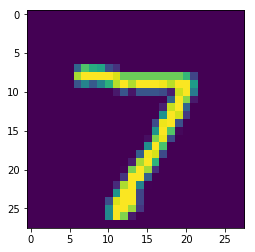

Prediction 7


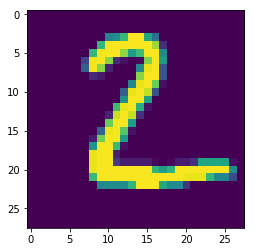

Prediction 2


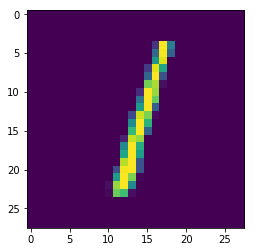

Prediction 1


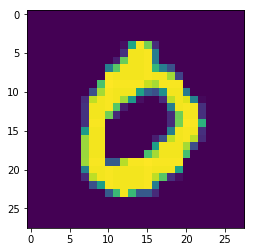

Prediction 0


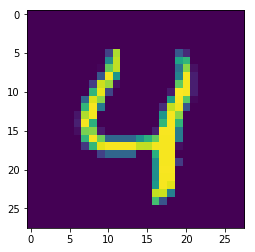

Prediction 4


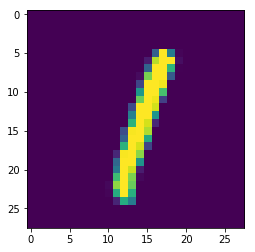

Prediction 1


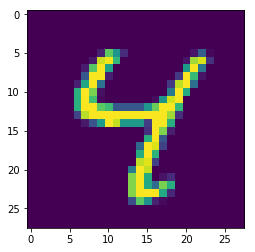

Prediction 4


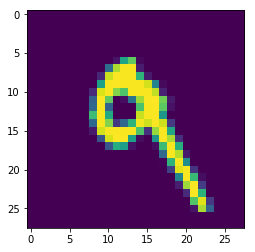

Prediction 9


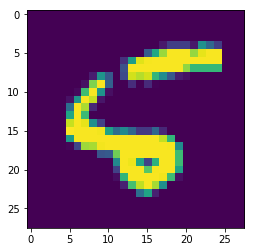

Prediction 5


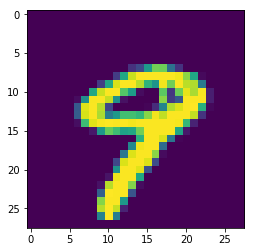

Prediction 9


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

tf.logging.set_verbosity(tf.logging.INFO)


# 通过tf.layers来定义模型结构。这里可以使用原生态TensorFlow API或者任何TensorFlow
# 的高层封装。x给出了输入层张量，is_training指明了是否为训练。该函数返回前向传播的结果。
def lenet(x, is_training):
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
    conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
    conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
    conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
    fc1 = tf.contrib.layers.flatten(conv2)
    fc1 = tf.layers.dense(fc1, 1024)
    fc1 = tf.layers.dropout(fc1, rate=0.4, training=is_training)
    return tf.layers.dense(fc1, 10)


# 自定义Estimator中使用的模型。定义的函数有4 个输入：
#    features给出了在输入函数中会提供的输入层张量。注意这是一个字典，字典里的内容是
#       通过tf.estimator.inputs.numpy_input_fn中x参数的内容指定的。
#    labels是正确答案，这个字段的内容是通过numpy_input_fn 中y参数给出的。
#    mode 的取值有3 种可能，分别对应Estimator类的train 、evaluate和predict这3 个函数。
#       通过这个参数可以判断当前是有是训练过程。
#    params是一个字典，这个字典中可以给出模型相关的任何超参数。比如这里的学习率。
def model_fn(features, labels, mode, params):
    # 定义神经网络的结构并通过输入得到前向传播的结果
    predict = lenet(
        features["image"], mode == tf.estimator.ModeKeys.TRAIN)

    # 如果在预测模式，那么只需要将前向传播结果返回
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions={"result": tf.argmax(predict, 1)})

    # 定义损失函数
    loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
           logits=predict, labels=labels))

    # 定义优化函数
    optimizer = tf.train.GradientDescentOptimizer(
        learning_rate=params["learning_rate"])

    # 定义训练过程
    train_op = optimizer.minimize(
        loss=loss, global_step=tf.train.get_global_step())

    # 定义评价标准
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            tf.argmax(predict, 1), labels)
    }

    # 返回模型训练过程需要使用的损失函数、训练过程和评测方法
    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops)


# 建立Estimator
model_params = {"learning_rate": 0.01}
estimator = tf.estimator.Estimator(model_fn=model_fn, 
                                   params=model_params,
                                   model_dir='log')

# 加载数据
mnist = input_data.read_data_sets("../../datasets/MNIST_data", one_hot=False)

# 训练
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"image": mnist.train.images},
      y=mnist.train.labels.astype(np.int32),
      num_epochs=None,
      batch_size=128,
      shuffle=True)

estimator.train(input_fn=train_input_fn, steps=10000)

# 测试
test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"image": mnist.test.images},
      y=mnist.test.labels.astype(np.int32),
      num_epochs=1,
      batch_size=128,
      shuffle=False)

test_results = estimator.evaluate(input_fn=test_input_fn)
print("\ntest_results: ", test_results, '\n')

# 预测
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"image": mnist.test.images[:10]},
      num_epochs=1,
      shuffle=False)

predictions = estimator.predict(input_fn=predict_input_fn)
for i, p in enumerate(predictions):
    plt.imshow(mnist.test.images[i].reshape([28, 28]))
    plt.show()
    print("Prediction %s" % p["result"])

可以看出，**Estimator能非常好地支持自定义模型，而且模型结构的定义过程中也可以使用其他的TensorFlow高层封装（比如代码中使用到的tf.layers）。Estimator在支持自定义模型结构的同时，并不影响它对训练过程的封装。**

### 10.3.3 使用数据集（datasets）作为Estimator输入
为了更加方便地介绍数据集（Dataset）和Estimator的结合方法，本节将使用[iris分类数据集](http://archive.ics.uci.edu/ml/datasets/Iris)。iris数据集需要通过**4个特征来分辨3种类型的植物**。iris 数据集中总共包含了**150个样本，其中包括120条训练数据、30条测试数据**。这些数据都存储在csv 文件中。以下代码介绍了如何通过Estimator 和数据集相结合的方式完成整个数据读取和模型训练的过程。

In [1]:
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

# Estimator的自定义输入函数需要每一次被调用时可以得到一个batch的数据（包括所有的
# 输入层数据和期待的正确答案标注），通过数据集可以很自然地实现这个过程。虽然Estimator
# 要求的自定义输入函数不能有参数，但是通过pythoy提供的lambda表达式可以快速将下面的
# 函数转化为不带参数的函数。
def my_input_fn(file_path, perform_shuffle=False, repeat_count=1):
    # 解析csv文件中一行
    def decode_csv(line):
        parsed_line = tf.decode_csv(line, [[0.], [0.], [0.], [0.], [0]])
        # Estimator的输入函数要求特征是一个字典，所以这里返回的也需要是一个字典。
        # 字典中key的定义需要和DNNClassifier中feature_columns的定义匹配：x。
        return {"x": parsed_line[:-1]}, parsed_line[-1:]

    # 使用数据集输入数据。具体使用方法参考第7章。
    dataset = tf.data.TextLineDataset(file_path).skip(1).map(decode_csv)
    if perform_shuffle:
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count) 
    dataset = dataset.batch(32) 
    iterator = dataset.make_one_shot_iterator()
    # 通过定义的数据集得到一个batch的输入数据。这个就是整个自定义的输入过程的返回结果
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels

# 与10.3.1小节中类似地定义Estimator
feature_columns = [tf.feature_column.numeric_column("x", shape=[4])]
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,  
    hidden_units=[10, 10],  
    n_classes=3)

# 使用lambda表达式将训练的相关信息传入自定义输入数据处理函数，并生成需要的输入函数
classifier.train(
    input_fn=lambda: my_input_fn("../../datasets/iris_training.csv", True, 100))

# 对于测试，同样使用lambda，这样可以大大减少冗余代码
test_results = classifier.evaluate(
    input_fn=lambda: my_input_fn("../../datasets/iris_test.csv", False, 1))
print("\nTest accuracy: %g %%" % (test_results["accuracy"]*100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\MSI-PC\\AppData\\Local\\Temp\\tmpahgtht_g', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E8A3D0CC88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Check

通过以上代码，可以看出Estimator可以非常好地和数据集结合，这样就能够很容易地支持海量数据读入或者复杂的数据预处理流程。